# 顔検出を用いた国会写真の人物状態分析

## 1. 目的
本レポートでは、国会中の写真を対象として、
画像中に写る人物の顔向きおよび目の開閉状態を分析することを目的とする。

顔検出には YOLO を用い、その後 MediaPipe Face Mesh を用いて
顔のランドマーク情報を取得することで、
以下の4種類に人物を分類し、可視化を行った。

- 目が開いていて前を向いている人物
- 目を閉じているが前を向いている人物
- 下を向いている人物
- 顔情報が十分に取得できず判別できなかった人物


## 2. 使用技術

- Python 3.10
- YOLOv8（人物検出）
- MediaPipe Face Mesh（顔ランドマーク検出）
- OpenCV / NumPy / Matplotlib

YOLO により画像中の人物領域を検出し、
検出された人物ごとに Face Mesh を適用することで、
目の開閉および顔の向きを推定した。


In [1]:
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO
import matplotlib.pyplot as plt

model = YOLO("yolov8n.pt")

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=50,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.3
)


## 3. 判定方法

### 3.1 目の開閉判定
目の開閉状態は、Eye Aspect Ratio（EAR）を用いて判定した。
左右の目それぞれの EAR を計算し、両目が一定以上の値を持つ場合に
「目が開いている」と判定した。

### 3.2 顔向き判定
顔の向きは、目の位置と鼻の位置の縦方向の差を用いて推定した。
人物の顔サイズに応じて正規化することで、
遠近による誤判定を減らす工夫を行った。


In [2]:
def calc_ear(eye):
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    return (A + B) / (2.0 * C)


## 4. 分類ルール

本プログラムでは、人物を以下の4種類に分類した。

- 緑：目が開いており、前を向いている人物
- 黄：目を閉じているが、前を向いている人物
- 赤：下を向いている人物
- 青：人物検出はできたが、顔の詳細解析ができなかった人物

青色の分類はエラーではなく、
集合写真におけるモデルの限界を示すものとして扱った。


In [ ]:
image_paths = [
    "inemuri.jpg",
    "inemuri2.jpg",
    "inemuri3.jpg"
]


image_paths = [
    "inemuri.jpg",
    "inemuri2.jpg",
    "inemuri3.jpg"
]

for i, img_path in enumerate(image_paths, start=1):
    print("processing:", img_path)

    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape
    output = img_bgr.copy()

    # =====================
    # YOLOで人物検出
    # =====================
    results = model(img_rgb)

    for r in results:
        if r.boxes is None:
            continue

        for box in r.boxes:
            if model.names[int(box.cls[0])] != "person":
                continue

            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)

            person_rgb = img_rgb[y1:y2, x1:x2]
            if person_rgb.size == 0:
                continue

            # =====================
            # FaceMesh
            # =====================
            mesh_results = face_mesh.process(person_rgb)

            # 🔵 顔判定できない
            if not mesh_results.multi_face_landmarks:
                color = (255, 0, 0)
                label = "face_not_detected"

            else:
                face = mesh_results.multi_face_landmarks[0]
                lm = face.landmark
                ph, pw, _ = person_rgb.shape

                # 目ランドマーク
                left_idx  = [33, 160, 158, 133, 153, 144]
                right_idx = [362, 385, 387, 263, 373, 380]

                left_eye = np.array([[lm[i].x*pw, lm[i].y*ph] for i in left_idx])
                right_eye = np.array([[lm[i].x*pw, lm[i].y*ph] for i in right_idx])

                def calc_ear(eye):
                    A = np.linalg.norm(eye[1] - eye[5])
                    B = np.linalg.norm(eye[2] - eye[4])
                    C = np.linalg.norm(eye[0] - eye[3])
                    return (A + B) / (2.0 * C)

                ear = (calc_ear(left_eye) + calc_ear(right_eye)) / 2
                eyes_open = ear > 0.22

                nose = np.array([lm[1].x*pw, lm[1].y*ph])
                eye_center = (left_eye[0] + right_eye[3]) / 2
                looking_down = (nose[1] - eye_center[1]) > ph * 0.15

                if looking_down:
                    color = (0, 0, 255)     # 🔴
                    label = "looking_down"
                else:
                    if eyes_open:
                        color = (0, 255, 0) # 🟢
                        label = "open_front"
                    else:
                        color = (0, 255, 255) # 🟡
                        label = "closed_front"

            cv2.rectangle(output, (x1, y1), (x2, y2), color, 2)
            cv2.putText(output, label, (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # =====================
    # 保存（描画後）
    # =====================
    h, w, _ = output.shape
    new_w = 800
    new_h = int(new_w * h / w)
    small_img = cv2.resize(output, (new_w, new_h))

    save_name = f"result_inemuri{i}.jpg"
    cv2.imwrite(save_name, small_img)
    print("saved:", save_name)


## 実行結果

以下に、3枚の国会写真に対して本プログラムを実行した結果を示す。

### 画像1
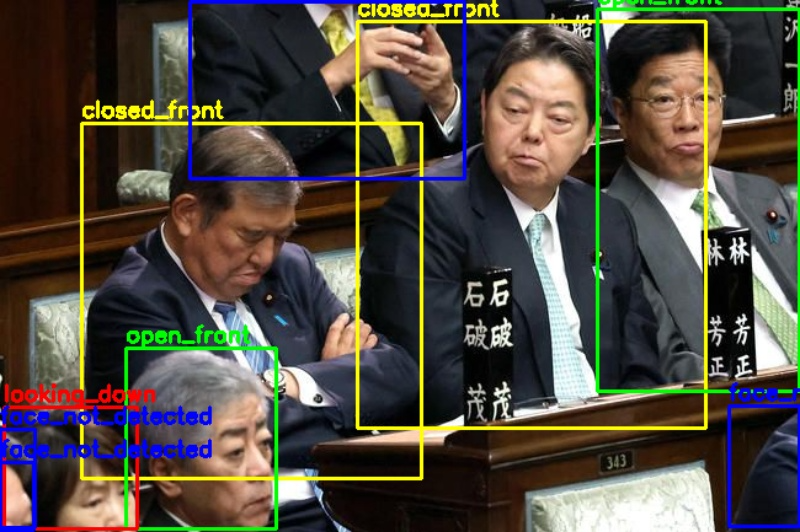

### 画像2
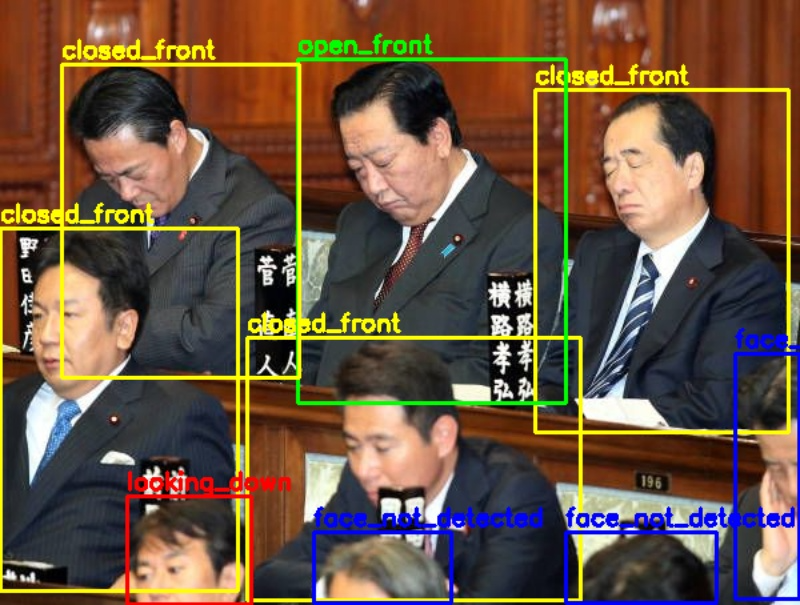

### 画像3
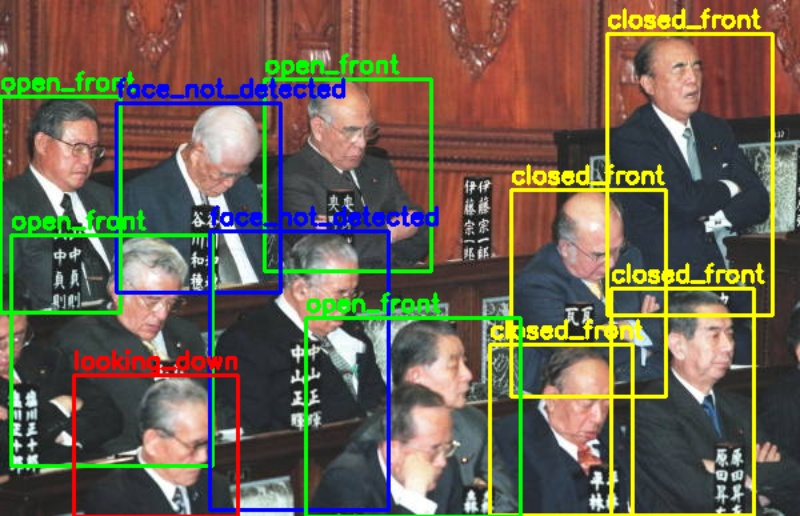

## 5. 考察

国会写真のような集合画像では、人物が小さく写るため、
YOLOでは人物検出が可能であっても、
Face Mesh による顔解析が困難なケースが多く見られた。

一方で、顔情報が取得できた人物については、
目の開閉や顔向きによる分類が可能であり、
姿勢や注目状態の傾向を把握できることが分かった。

## 6. まとめ
本課題を通して、顔検出と顔特徴解析を組み合わせることで、
画像中の人物状態を可視化できることを確認した。
また、撮影条件や画像解像度が解析精度に大きく影響することを理解した。
